# 0) Install gmshparser

- gmsh helps parse .msh files for use in Python.
- In python:
    - lists are ordered, mutable, and can store different data types
    - dicts are ordered, and do not allow duplicates

In [88]:
# pip install gmshparser
# https://github.com/ahojukka5/gmshparser

# 1) First Look at gmshparser

we first experiment with the file "2D_square_lattice_threes.msh" file, is a square mesh defined over a square region of size 1 by 1 consisting of 9 squares of size length 1/3. 

#### get summary of mesh by creating "mesh" object

In [89]:
import gmshparser
mesh = gmshparser.parse("2D_square_lattice_threes.msh") #replace file location here
print(mesh) # mesh object contains all info

Mesh name: 2D_square_lattice_threes.msh
Mesh version: 4.1
Number of nodes: 16
Minimum node tag: 1
Maximum node tag: 16
Number of node entities: 9
Number of elements: 25
Minimum element tag: 1
Maximum element tag: 25
Number of element entities: 9


#### create dict of all nodes (key is node id, value is node coordinate). Note, we convert tuples (default from .msh) to arrays here for later convenience (e.g. np arrays are usually more efficient).

In [90]:
import numpy as np

node_dict = {}

# extract all nodes, and populate dict
for entity in mesh.get_node_entities():
    
    for node in entity.get_nodes():
        
        nid = node.get_tag()
        ncoords = node.get_coordinates()
        node_dict[nid] = np.array(ncoords) # create dict of nodes, key is id, value is coordinate
        
        #print("Node id = %s, node coordinates = %s" % (nid, ncoords))

node_dict

{1: array([-0.,  0.,  0.]),
 2: array([1., 0., 0.]),
 3: array([1., 1., 0.]),
 4: array([0., 1., 0.]),
 5: array([0.33333333, 0.        , 0.        ]),
 6: array([0.66666667, 0.        , 0.        ]),
 7: array([1.        , 0.33333333, 0.        ]),
 8: array([1.        , 0.66666667, 0.        ]),
 9: array([0.66666667, 1.        , 0.        ]),
 10: array([0.33333333, 1.        , 0.        ]),
 11: array([0.        , 0.66666667, 0.        ]),
 12: array([0.        , 0.33333333, 0.        ]),
 13: array([0.66666667, 0.66666667, 0.        ]),
 14: array([0.66666667, 0.33333333, 0.        ]),
 15: array([0.33333333, 0.66666667, 0.        ]),
 16: array([0.33333333, 0.33333333, 0.        ])}

#### print all elements (element type: 15 means a 1-node point, 1 means a 2-node line, 3 means a 4-node quadrangle (e.g square or rectangle))

In [91]:
# extract all elements, which are each defined via nodes
for entity in mesh.get_element_entities():
    eltype = entity.get_element_type()
    print("Element type: %s" % eltype)
    for element in entity.get_elements():
        elid = element.get_tag()
        elcon = element.get_connectivity()
        print("Element id = %s, connectivity = %s" % (elid, elcon))

Element type: 15
Element id = 1, connectivity = [1]
Element type: 15
Element id = 2, connectivity = [2]
Element type: 15
Element id = 3, connectivity = [3]
Element type: 15
Element id = 4, connectivity = [4]
Element type: 1
Element id = 5, connectivity = [1, 5]
Element id = 6, connectivity = [5, 6]
Element id = 7, connectivity = [6, 2]
Element type: 1
Element id = 8, connectivity = [2, 7]
Element id = 9, connectivity = [7, 8]
Element id = 10, connectivity = [8, 3]
Element type: 1
Element id = 11, connectivity = [3, 9]
Element id = 12, connectivity = [9, 10]
Element id = 13, connectivity = [10, 4]
Element type: 1
Element id = 14, connectivity = [4, 11]
Element id = 15, connectivity = [11, 12]
Element id = 16, connectivity = [12, 1]
Element type: 3
Element id = 17, connectivity = [3, 9, 13, 8]
Element id = 18, connectivity = [8, 13, 14, 7]
Element id = 19, connectivity = [7, 14, 6, 2]
Element id = 20, connectivity = [9, 10, 15, 13]
Element id = 21, connectivity = [13, 15, 16, 14]
Element

#### create dict of boundary edges (key is element id, value is a list of nodes in the element)

In [92]:
edge_dict = {}
# populate edges dict
for entity in mesh.get_element_entities():
    eltype = entity.get_element_type()
    if eltype == 1:
        for element in entity.get_elements():
            elid = element.get_tag()
            elcon = element.get_connectivity()
            edge_dict[elid] = elcon

In [93]:
edge_dict

{5: [1, 5],
 6: [5, 6],
 7: [6, 2],
 8: [2, 7],
 9: [7, 8],
 10: [8, 3],
 11: [3, 9],
 12: [9, 10],
 13: [10, 4],
 14: [4, 11],
 15: [11, 12],
 16: [12, 1]}

#### create dict of all quadrangles (key is element id, value is a list of nodes in the element)

In [94]:
quadrangle_dict = {}
# populate faces dict
for entity in mesh.get_element_entities():
    eltype = entity.get_element_type()
    if eltype == 3:
        for element in entity.get_elements():
            elid = element.get_tag()
            elcon = element.get_connectivity()
            quadrangle_dict[elid] = elcon

In [95]:
quadrangle_dict

{17: [3, 9, 13, 8],
 18: [8, 13, 14, 7],
 19: [7, 14, 6, 2],
 20: [9, 10, 15, 13],
 21: [13, 15, 16, 14],
 22: [14, 16, 5, 6],
 23: [10, 4, 11, 15],
 24: [15, 11, 12, 16],
 25: [16, 12, 1, 5]}

#### create dict of all edges from the quadrangles (key is element id, value is a list of nodes in the element)

In [96]:
quadrangle_edge_dict = {}
# dict of list of edges belonging to each quadrangle
for element_id in quadrangle_dict.keys():
    edge_list = []
    nodes = quadrangle_dict[element_id]
    for i in range(len(nodes)):
        if i == len(nodes)-1:
            edge = [nodes[i], nodes[0]]
        else:
            edge = [nodes[i], nodes[i+1]]
        edge_list.append(edge)
    quadrangle_edge_dict[element_id] = edge_list
    
quadrangle_edge_dict

{17: [[3, 9], [9, 13], [13, 8], [8, 3]],
 18: [[8, 13], [13, 14], [14, 7], [7, 8]],
 19: [[7, 14], [14, 6], [6, 2], [2, 7]],
 20: [[9, 10], [10, 15], [15, 13], [13, 9]],
 21: [[13, 15], [15, 16], [16, 14], [14, 13]],
 22: [[14, 16], [16, 5], [5, 6], [6, 14]],
 23: [[10, 4], [4, 11], [11, 15], [15, 10]],
 24: [[15, 11], [11, 12], [12, 16], [16, 15]],
 25: [[16, 12], [12, 1], [1, 5], [5, 16]]}

Thus we see that now it is possible to query quadrangle_edge_dict with a quadrangle id (returning a list of edges corresponding to that quadrature).

#### create dict of quadrangle areas (we use the shoelace formula here, but for triangles later we can use either heron's formula or the half-cross product formula. Note that heron's formula may run into problems with thin triangles due to rounding errors present in the terms with subtraction.)

define function to calculate quadrangle area (works for any quadrangle)

In [97]:
def quadrangle_area(quadrangle_id):
    # get list of quadrangle nodes
    quadrangle_nodes = quadrangle_dict[quadrangle_id]
    # get coordinates of nodes
    x1 = node_dict[quadrangle_nodes[0]][0]
    y1 = node_dict[quadrangle_nodes[0]][1]
    z1 = node_dict[quadrangle_nodes[0]][2]
    x2 = node_dict[quadrangle_nodes[1]][0]
    y2 = node_dict[quadrangle_nodes[1]][1]
    z2 = node_dict[quadrangle_nodes[1]][2]
    x3 = node_dict[quadrangle_nodes[2]][0]
    y3 = node_dict[quadrangle_nodes[2]][1]
    z3 = node_dict[quadrangle_nodes[2]][2]
    x4 = node_dict[quadrangle_nodes[3]][0]
    y4 = node_dict[quadrangle_nodes[3]][1]
    z4 = node_dict[quadrangle_nodes[3]][2]
    # calculate area using shoelace formula, z coords are not needed since we are in 2d
    # https://www.onlinemath4all.com/area-of-quadrilateral-when-four-vertices-are-given.html
    quadrangle_area = 0.5 * ((x1*y2 + x2*y3 + x3*y4 + x4*y1) - (x2*y1 + x3*y2 + x4*y3 + x1*y4))
    return quadrangle_area

In [98]:
quadrangle_area(17)

0.11111111111109584

create dict

In [99]:
quadrangle_area_dict = {}
for element_id in quadrangle_dict.keys():
    area = quadrangle_area(element_id)
    quadrangle_area_dict[element_id] = area

quadrangle_area_dict

{17: 0.11111111111109584,
 18: 0.11111111111106475,
 19: 0.11111111111114982,
 20: 0.1111111111109725,
 21: 0.1111111111109413,
 22: 0.11111111111116494,
 23: 0.11111111111124211,
 24: 0.11111111111107261,
 25: 0.11111111111129614}

These are indeed the correct areas, as each square as area $\frac{1}{3} * \frac{1}{3} = \frac{1}{9} \approx 0.11$. Now, let us visualize the primal mesh by plotting it.

In [100]:
def plot_node(ax, nodecoords):
    ax.scatter(nodecoords[0], nodecoords[1], nodecoords[2], c='purple', s=200)
    
def plot_edge(ax, edgestartcoords, edgeendcoords):
    # create parameterization between endpoints using parameter t
    t_array = np.linspace(0, 1, 100)
    for t in t_array:
        point = t*edgestartcoords + (1-t)*edgeendcoords
        ax.scatter(point[0], point[1], point[2], c='black', s=20)

In [101]:
def plot_quadrangle(ax, quadrangle_id):
    quadrangle_nodes = quadrangle_dict[quadrangle_id]
    # plot nodes
    for node in quadrangle_nodes:
        # get coords of node
        coords = node_dict[node]
        # plot 
        plot_node(ax, coords)
    # plot edges
    edges_list = quadrangle_edge_dict[quadrangle_id]
    for edge in edges_list:
        start = edge[0] # gives a node_id
        startcoords = node_dict[start]
        end = edge[1]
        endcoords = node_dict[end]
        plot_edge(ax, startcoords, endcoords)

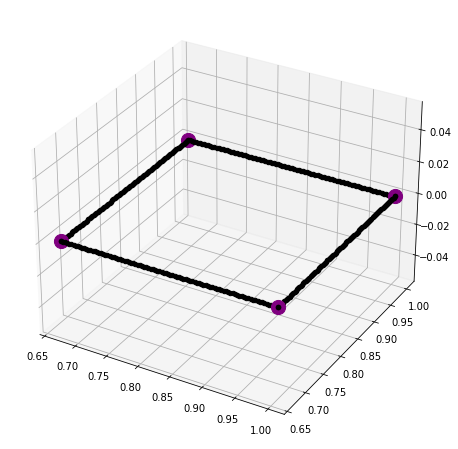

In [102]:
# plot a single quadrangle (nodes and edges)
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_size_inches(8, 8)
ax = plt.axes(projection='3d')

plot_quadrangle(ax, 17)

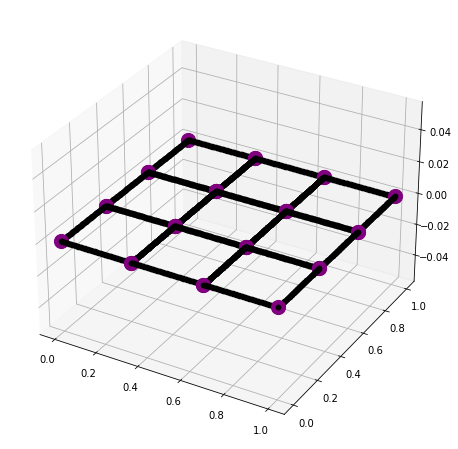

In [103]:
# plot the entire mesh
fig = plt.figure()
fig.set_size_inches(8, 8)
ax = plt.axes(projection='3d')

def plot_mesh(ax):
    for quadrangle_id in quadrangle_dict.keys():
        plot_quadrangle(ax, quadrangle_id)

plot_mesh(ax)

#### Creating the dual mesh

The dual mesh will consist of:
- dual vertices (nodes) which lie at the centers of each of the quadrangles; since here the quadrangles are just rectangles, we can get this by just considering the midpoints of a diagonal. Eventually for tetrahedrons, we'd like to use the full formula for the circumcenters,  or whatever type of center we want to calculate.
- for any two primal quadrangles sharing a side, there exist a dual edge which connects their dual vertices 

In [104]:
# only works for rectangles
def create_dual_node_coords(quadrangle_id):
    quadrangle_nodes = quadrangle_dict[quadrangle_id]
    x1 = node_dict[quadrangle_nodes[0]][0]
    y1 = node_dict[quadrangle_nodes[0]][1]
    z1 = node_dict[quadrangle_nodes[0]][2]
    x3 = node_dict[quadrangle_nodes[2]][0]
    y3 = node_dict[quadrangle_nodes[2]][1]
    z3 = node_dict[quadrangle_nodes[2]][2]
    x_dual_node = (x1+x3)/2
    y_dual_node = (y1+y3)/2
    z_dual_node = (z1+z3)/2
    dual_node_coords = np.array([x_dual_node, y_dual_node, z_dual_node])
    return dual_node_coords

In [105]:
# create dict of dual nodes (key is quadrangle id, value is dual node coords)
dual_node_dict = {}
for element_id in quadrangle_dict.keys():
    dual_node_dict[element_id] = create_dual_node_coords(element_id)

dual_node_dict

{17: array([0.83333333, 0.83333333, 0.        ]),
 18: array([0.83333333, 0.5       , 0.        ]),
 19: array([0.83333333, 0.16666667, 0.        ]),
 20: array([0.5       , 0.83333333, 0.        ]),
 21: array([0.5, 0.5, 0. ]),
 22: array([0.5       , 0.16666667, 0.        ]),
 23: array([0.16666667, 0.83333333, 0.        ]),
 24: array([0.16666667, 0.5       , 0.        ]),
 25: array([0.16666667, 0.16666667, 0.        ])}

#### plot dual nodes

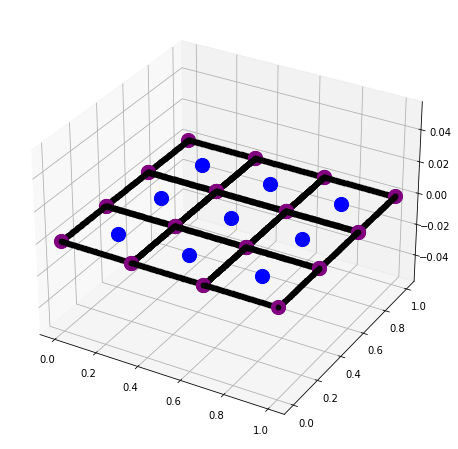

In [106]:
def plot_dual_node(ax, nodecoords):
    ax.scatter(nodecoords[0], nodecoords[1], nodecoords[2], c='blue', s=200)

# plot the entire mesh
fig = plt.figure()
fig.set_size_inches(8, 8)
ax = plt.axes(projection='3d')

plot_mesh(ax)

for quadrangle_id in quadrangle_dict:
    # get coords of dual node
    coords = dual_node_dict[quadrangle_id]
    # plot 
    plot_dual_node(ax, coords)

In [107]:
dual_edge_dict = {}
''' 
key: frozenset (immutable set) of primal quadrangle ids sharing the dual edge
value: coords of endpoints of dual edge
'''

for quadrangle_id_1 in quadrangle_edge_dict.keys():
    edge_list_1 = quadrangle_edge_dict[quadrangle_id_1]
    for edge_1 in edge_list_1:
        for quadrangle_id_2 in quadrangle_edge_dict.keys():
            edge_list_2 = quadrangle_edge_dict[quadrangle_id_2]
            if quadrangle_id_1 != quadrangle_id_2:
                if edge_1 in edge_list_2:
                    #form dual edge connecting centers of two adjacent quadrangles
                    dual_edge = [dual_node_dict[quadrangle_id_1], dual_node_dict[quadrangle_id_2]]
                    dual_edge_dict[frozenset({quadrangle_id_1, quadrangle_id_2})] = dual_edge 
                if edge_1[::-1] in edge_list_2: # this notation flips the list 
                    #form dual edge connecting centers of two adjacent quadrangles
                    dual_edge = [dual_node_dict[quadrangle_id_1], dual_node_dict[quadrangle_id_2]]
                    dual_edge_dict[frozenset({quadrangle_id_1, quadrangle_id_2})] = dual_edge 

In [108]:
dual_edge_dict

{frozenset({17, 20}): [array([0.5       , 0.83333333, 0.        ]),
  array([0.83333333, 0.83333333, 0.        ])],
 frozenset({17, 18}): [array([0.83333333, 0.5       , 0.        ]),
  array([0.83333333, 0.83333333, 0.        ])],
 frozenset({18, 21}): [array([0.5, 0.5, 0. ]),
  array([0.83333333, 0.5       , 0.        ])],
 frozenset({18, 19}): [array([0.83333333, 0.16666667, 0.        ]),
  array([0.83333333, 0.5       , 0.        ])],
 frozenset({19, 22}): [array([0.5       , 0.16666667, 0.        ]),
  array([0.83333333, 0.16666667, 0.        ])],
 frozenset({20, 23}): [array([0.16666667, 0.83333333, 0.        ]),
  array([0.5       , 0.83333333, 0.        ])],
 frozenset({20, 21}): [array([0.5, 0.5, 0. ]),
  array([0.5       , 0.83333333, 0.        ])],
 frozenset({21, 24}): [array([0.16666667, 0.5       , 0.        ]),
  array([0.5, 0.5, 0. ])],
 frozenset({21, 22}): [array([0.5       , 0.16666667, 0.        ]),
  array([0.5, 0.5, 0. ])],
 frozenset({22, 25}): [array([0.16666667

In [109]:
def plot_dual_edge(ax, edgestartcoords, edgeendcoords):
    t_array = np.linspace(0, 1, 100)
    for t in t_array:
        point = t*edgestartcoords + (1-t)*edgeendcoords
        ax.scatter(point[0], point[1], point[2], c='grey', s=20)

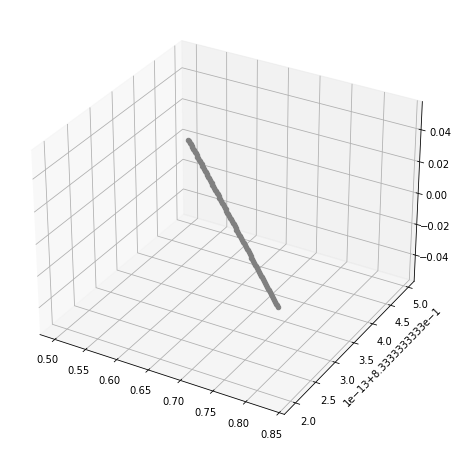

In [110]:
# plot a single dual edge, connecting the 17-th and 20-th indexed quadrangle
fig = plt.figure()
fig.set_size_inches(8, 8)
ax = plt.axes(projection='3d')

dualnodecoords = dual_edge_dict[frozenset({17, 20})]
plot_dual_edge(ax, dualnodecoords[0], dualnodecoords[1])

#### plot dual mesh on top of primal mesh

In [111]:
def plot_dual_mesh(ax):
    for dual_node_coords in dual_node_dict.values():
        plot_dual_node(ax, dual_node_coords)
    for dual_edge in dual_edge_dict.values():
        plot_dual_edge(ax, dual_edge[0], dual_edge[1])

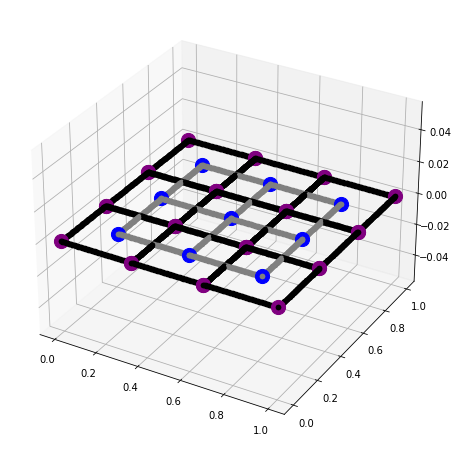

In [112]:
fig = plt.figure()
fig.set_size_inches(8, 8)
ax = plt.axes(projection='3d')

plot_mesh(ax) # black is primal mesh, nodes are purple
plot_dual_mesh(ax) # grey is dual mesh, nodes are blue

Eventually, we also want to include in the dual mash the boundary dual edges with are dual to the primal quadrangles at the boundary of the primal mesh (note: these edges terminate at the boundary of the primal mesh).

# 2. A deeper dive 

Now we experiment with the file "pyramid.msh" file, is a tetrahedral mesh defined over a pyramid with a square base (i.e. decomposed into two tetrahedrons). We also use a different data organization as before.

In [113]:
mesh = gmshparser.parse("transfinite_test.msh") 
#replace file location here, 
# "pyramid.msh"
# "cube_transfinite_3.msh"
# "cube_transfinite_dense.msh"


print(mesh) # mesh object contains all info

Mesh name: transfinite_test.msh
Mesh version: 4.1
Number of nodes: 45
Minimum node tag: 1
Maximum node tag: 45
Number of node entities: 27
Number of elements: 216
Minimum element tag: 1
Maximum element tag: 216
Number of element entities: 27


#### primal mesh

In [114]:
import numpy as np

node_dict = {}
"""
key: node_id (int)
value: node_coords (array of floats)
"""

for entity in mesh.get_node_entities():
    for node in entity.get_nodes():
        node_id = node.get_tag()
        node_coords = node.get_coordinates()
        node_dict[node_id] = np.array(node_coords) # create dict of nodes, key is id, value is coordinate
        # print("Node id = %s, node coordinates = %s" % (nid, ncoords))

node_dict
node_dict 

{1: array([-0.5, -0.5,  0.5]),
 2: array([ 0.5, -0.5,  0.5]),
 3: array([ 0.5, -0.5, -0.5]),
 4: array([-0.5, -0.5, -0.5]),
 5: array([-0.5,  0.5,  0.5]),
 6: array([0.5, 0.5, 0.5]),
 7: array([ 0.5,  0.5, -0.5]),
 8: array([-0.5,  0.5, -0.5]),
 9: array([-1.37512224e-12, -5.00000000e-01,  5.00000000e-01]),
 10: array([ 5.00000000e-01, -5.00000000e-01,  1.37512224e-12]),
 11: array([ 1.37512224e-12, -5.00000000e-01, -5.00000000e-01]),
 12: array([-5.00000000e-01, -5.00000000e-01, -1.37512224e-12]),
 13: array([-1.37512224e-12,  5.00000000e-01,  5.00000000e-01]),
 14: array([5.00000000e-01, 5.00000000e-01, 1.37512224e-12]),
 15: array([ 1.37512224e-12,  5.00000000e-01, -5.00000000e-01]),
 16: array([-5.00000000e-01,  5.00000000e-01, -1.37512224e-12]),
 17: array([-5.00000000e-01, -1.37512224e-12,  5.00000000e-01]),
 18: array([-5.00000000e-01, -1.37512224e-12, -5.00000000e-01]),
 19: array([ 5.00000000e-01, -1.37512224e-12,  5.00000000e-01]),
 20: array([ 5.00000000e-01, -1.37512224e-12

In [115]:
tetrahedron_dict = {}
"""
key: tetrahedron_id (int)
value: node_ids (array of ints)
"""
for entity in mesh.get_element_entities():
    el_type = entity.get_element_type()
    if el_type == 4:
        for element in entity.get_elements():
            el_id = element.get_tag()
            el_con = element.get_connectivity()
            tetrahedron_dict[el_id] = np.array(el_con)

tetrahedron_dict

{109: array([21, 40, 24, 45]),
 110: array([42, 23, 44, 45]),
 111: array([27, 29, 31, 45]),
 112: array([33, 26, 25, 45]),
 113: array([44, 23, 30, 45]),
 114: array([21, 34, 40, 45]),
 115: array([27, 43, 29, 45]),
 116: array([33, 25, 39, 45]),
 117: array([38, 24, 40, 45]),
 118: array([26, 33, 35, 45]),
 119: array([42, 23, 45, 22]),
 120: array([42, 35, 36, 45]),
 121: array([41, 35, 42, 45]),
 122: array([27, 31, 28, 45]),
 123: array([24, 30, 23, 45]),
 124: array([12, 21, 40, 24]),
 125: array([36, 22, 42, 45]),
 126: array([29, 31, 13, 27]),
 127: array([33, 25, 26, 15]),
 128: array([41, 26, 35, 45]),
 129: array([26, 41, 43, 45]),
 130: array([42, 23, 22, 10]),
 131: array([43, 44, 30, 45]),
 132: array([36, 34, 22, 45]),
 133: array([21, 22, 34, 45]),
 134: array([32, 30, 24, 45]),
 135: array([39, 34, 33, 45]),
 136: array([39, 40, 34, 45]),
 137: array([29, 43, 30, 45]),
 138: array([28, 37, 39, 45]),
 139: array([28, 39, 25, 45]),
 140: array([32, 24, 38, 45]),
 141: ar

In [116]:
tetrahedron_volume_dict = {}
"""
key: tetrahedron_id (int)
value: volume of tetrahedron (float)
"""
def tetrahedron_volume(tetrahedron_id):
    # get coordinates of nodes
    nodes = tetrahedron_dict[tetrahedron_id]
    x1 = node_dict[nodes[0]][0]
    y1 = node_dict[nodes[0]][1]
    z1 = node_dict[nodes[0]][2]
    x2 = node_dict[nodes[1]][0]
    y2 = node_dict[nodes[1]][1]
    z2 = node_dict[nodes[1]][2]
    x3 = node_dict[nodes[2]][0]
    y3 = node_dict[nodes[2]][1]
    z3 = node_dict[nodes[2]][2]
    x4 = node_dict[nodes[3]][0]
    y4 = node_dict[nodes[3]][1]
    z4 = node_dict[nodes[3]][2]
    # use cross-product formula to get volume
    # https://keisan.casio.com/has10/SpecExec.cgi?path=05000000.Mathematics/01000
    # 600.Space%2520geometry/10000
    # 300.Volume%2520of%2520a%2520tetrahedron%2520and%2520a%2520parallelepiped/
    # default.xml&charset=utf-8
    volume = 1/6 * (
        (x4-x1)*((y2-y1)*(z3-z1)-(z2-z1)*(y3-y1)) +
        (y4-y1)*((z2-z1)*(x3-x1)-(x2-x1)*(z3-z1)) +
        (z4-z1)*((x2-x1)*(y3-y1)-(y2-y1)*(x3-x1))
    )
    return volume

for tetrahedron_id in tetrahedron_dict:
    tetrahedron_volume_dict[tetrahedron_id] = tetrahedron_volume(tetrahedron_id)
    
tetrahedron_volume_dict

{109: 0.012359275268061224,
 110: 0.010895996217847545,
 111: 0.011402778230058795,
 112: 0.01060252490141576,
 113: 0.014361348313459015,
 114: 0.013835114065446826,
 115: 0.01335409300265088,
 116: 0.012684922589251458,
 117: 0.014199896696366315,
 118: 0.015258756192942017,
 119: 0.014527994957123026,
 120: 0.013369737714920582,
 121: 0.012602365169728225,
 122: 0.014257640795448178,
 123: 0.01351241314729074,
 124: 0.005859375000009848,
 125: 0.016545100976204586,
 126: 0.005670575289262077,
 127: 0.005445593415951522,
 128: 0.01532858487623712,
 129: 0.013297142776109072,
 130: 0.007324218749986573,
 131: 0.0131104455499306,
 132: 0.012511542700944237,
 133: 0.013389093793037044,
 134: 0.01185233528070532,
 135: 0.012391587681733453,
 136: 0.013198115648088326,
 137: 0.01239732574667533,
 138: 0.012647985387768512,
 139: 0.01344625454433455,
 140: 0.015579774435355683,
 141: 0.011888371398457373,
 142: 0.01441950394204738,
 143: 0.011790838040179951,
 144: 0.012938823483098343,
 1

In [117]:
face_dict = {}
"""
key: (node_id 1, node_id 2, node_id 3) (tuple of int)
    - nodes that make up the face in ascending order of node id, with 
    - the ordering defining an orientation according to right hand rule
value: [tetrahedron_id 1, tetrahedron_id 2] (array of int)
    - all tetrahedrons that share this face. If the face is shared, len of array is 2, 
    - and face corresponds uniquely to a dual edge
    - Otherwise, len of array of 1.
"""
import itertools

for tetrahedron_id in tetrahedron_dict:
    
    # get nodes that make up tetrahedron
    tetrahedron_nodes = tetrahedron_dict[tetrahedron_id]
    
    # for a tetrahedron, any subset of 3 nodes of 4 form a valid face
    faces = list(itertools.combinations(tetrahedron_nodes, 3)) 
    
    value = tetrahedron_id
    
    for face in faces:
        
        key = list(face) # tuple is immutable, so need to convert to list first and sort, then convert back
        key.sort() # sorts in place
        key = tuple(key)
        
        # if face exists in dict
        if key in face_dict:
            face_dict[key] = np.append(face_dict[key], value)
        
        # otherwise 
        else: 
            face_dict[key] = np.array([value])

face_dict

{(21, 24, 40): array([109, 124]),
 (21, 40, 45): array([109, 114]),
 (21, 24, 45): array([109, 141]),
 (24, 40, 45): array([109, 117]),
 (23, 42, 44): array([110, 158]),
 (23, 42, 45): array([110, 119]),
 (42, 44, 45): array([110, 153]),
 (23, 44, 45): array([110, 113]),
 (27, 29, 31): array([111, 126]),
 (27, 29, 45): array([111, 115]),
 (27, 31, 45): array([111, 122]),
 (29, 31, 45): array([111, 156]),
 (25, 26, 33): array([112, 127]),
 (26, 33, 45): array([112, 118]),
 (25, 33, 45): array([112, 116]),
 (25, 26, 45): array([112, 154]),
 (23, 30, 44): array([113, 178]),
 (30, 44, 45): array([113, 131]),
 (23, 30, 45): array([113, 123]),
 (21, 34, 40): array([114, 183]),
 (21, 34, 45): array([114, 133]),
 (34, 40, 45): array([114, 136]),
 (27, 29, 43): array([115, 182]),
 (27, 43, 45): array([115, 143]),
 (29, 43, 45): array([115, 137]),
 (25, 33, 39): array([116, 185]),
 (33, 39, 45): array([116, 135]),
 (25, 39, 45): array([116, 139]),
 (24, 38, 40): array([117, 152]),
 (24, 38, 45):

In [118]:
face_area_dict = {}
"""
key: (node_id 1, node_id 2, node_id 3) (tuple of int)
    - nodes that make up the face in ascending order of node id, with 
    - the ordering defining an orientation according to right hand rule
value: face_area (array of int)
    - area of face (float)
"""

def triangle_area(tuple_of_node_id):
    node1 = node_dict[(tuple_of_node_id)[0]]
    node2 = node_dict[(tuple_of_node_id)[1]]
    node3 = node_dict[(tuple_of_node_id)[2]]
    side1 = node2 - node1
    side2 = node3 - node1
    side1x = side1[0]
    side1y = side1[1]
    side1z = side1[2]
    side2x = side2[0]
    side2y = side2[1]
    side2z = side2[2]
    area = 0.5 * np.sqrt(
        (side1y*side2z - side1z*side2y)**2 +
        (side1z*side2x - side1x*side2z)**2 +
        (side1x*side2y - side1y*side2x)**2
    )
    return area

for face in face_dict:
    face_area_dict[face] =  triangle_area(face)

face_area_dict

{(21, 24, 40): 0.0782362324892647,
 (21, 40, 45): 0.10832302796331464,
 (21, 24, 45): 0.11248440541912431,
 (24, 40, 45): 0.14266177258275187,
 (23, 42, 44): 0.06962246858385905,
 (23, 42, 45): 0.141071996842358,
 (42, 44, 45): 0.09463105240816312,
 (23, 44, 45): 0.11161404628493209,
 (27, 29, 31): 0.07484307147335824,
 (27, 29, 45): 0.10657812129872364,
 (27, 31, 45): 0.1362906430074793,
 (29, 31, 45): 0.10207324633326922,
 (25, 26, 33): 0.0702382057217055,
 (26, 33, 45): 0.1390522329829904,
 (25, 33, 45): 0.10407599354577833,
 (25, 26, 45): 0.10204504456397168,
 (23, 30, 44): 0.08645060554502257,
 (30, 44, 45): 0.12027403868195927,
 (23, 30, 45): 0.1205435216668292,
 (21, 34, 40): 0.0818217190065023,
 (21, 34, 45): 0.12194820383781824,
 (34, 40, 45): 0.12128039246135945,
 (27, 29, 43): 0.07904758959307145,
 (27, 43, 45): 0.11617506180705064,
 (29, 43, 45): 0.11698494646600512,
 (25, 33, 39): 0.07411902000012734,
 (33, 39, 45): 0.11656437739487549,
 (25, 39, 45): 0.1150423886829727,
 

In [119]:
edge_dict = {}
"""
key: (node_id 1, node_id 2) (tuple of int)
    - nodes that make up the edge in ascending order of node id, with the ordering defining a direction
value: [tetrahedron_id 1, tetrahedron_id 2, ...] (array of int)
    - all tetrahedrons that share the edge. Note, it is possible for an edge to belong to more than 2 tets.
    - Note: an edge can belong to just one tet, but at least two faces.
"""
import itertools

for face_id in face_dict:
    
    edges = list(itertools.combinations(face_id, 2)) # any subset of 2 vertices of 3 nodes form a valid edge
    
    values = face_dict[face_id] # all tetrahedrons that share this face
        
    for edge in edges:
        
        key = list(edge) # tuple is immutable, so need to convert to list first and sort, then convert back
        key.sort() # sorts in place, puts nodes of edge in ascending order
        key = tuple(key)
        
        for value in values:
            if key in edge_dict:
                    if value not in edge_dict[key]:
                        edge_dict[key] = np.append(edge_dict[key], value)
            else: 
                edge_dict[key] = np.array([value]) 
edge_dict

{(21, 24): array([109, 124, 141]),
 (21, 40): array([109, 124, 114, 183, 208]),
 (24, 40): array([109, 124, 117, 152]),
 (21, 45): array([109, 114, 141, 133]),
 (40, 45): array([109, 114, 117, 136, 169]),
 (24, 45): array([109, 141, 117, 140, 123, 134, 147]),
 (23, 42): array([110, 158, 119, 130]),
 (23, 44): array([110, 158, 113, 178, 206]),
 (42, 44): array([110, 158, 153]),
 (23, 45): array([110, 119, 113, 123, 147]),
 (42, 45): array([110, 119, 153, 125, 120, 121, 146]),
 (44, 45): array([110, 153, 113, 131]),
 (27, 29): array([111, 126, 115, 182, 204]),
 (27, 31): array([111, 126, 122, 150]),
 (29, 31): array([111, 126, 156]),
 (27, 45): array([111, 115, 122, 143, 177]),
 (29, 45): array([111, 115, 156, 137]),
 (31, 45): array([111, 122, 156, 142, 145, 144, 176]),
 (25, 26): array([112, 127, 154]),
 (25, 33): array([112, 127, 116, 185, 207]),
 (26, 33): array([112, 127, 118, 148]),
 (26, 45): array([112, 118, 154, 128, 129, 143, 177]),
 (33, 45): array([112, 118, 116, 135, 151]),


In [120]:
edge_length_dict = {}
"""
key: (node_id 1, node_id 2) (tuple of int)
    - nodes that make up the edge in ascending order of node id, with the ordering defining a direction
value: length of edge (float)
"""

def edge_length(edge_id):
    node1 = node_dict[(edge_id)[0]]
    node2 = node_dict[(edge_id)[1]]
    node1x = node1[0]
    node1y = node1[1]
    node1z = node1[2]
    node2x = node2[0]
    node2y = node2[1]
    node2z = node2[2]
    length = np.sqrt(
        (node2x - node1x)**2 + (node2y - node1y)**2 + (node2z - node1z)**2
    )
    return length

for edge_id in edge_dict:
    edge_length_dict[edge_id] = edge_length(edge_id)

edge_length_dict

{(21, 24): 0.41546967551137987,
 (21, 40): 0.3775951866757337,
 (24, 40): 0.5811851547324093,
 (21, 45): 0.621640117550733,
 (40, 45): 0.5901935583322029,
 (24, 45): 0.5525658031208311,
 (23, 42): 0.5812836011795245,
 (23, 44): 0.3977475644181927,
 (42, 44): 0.35630482034271926,
 (23, 45): 0.5968577847543437,
 (42, 45): 0.5388178263754393,
 (44, 45): 0.5940185074760046,
 (27, 29): 0.38447364261902295,
 (27, 31): 0.5768188836634047,
 (29, 31): 0.39149468872748905,
 (27, 45): 0.5785072424765115,
 (29, 45): 0.5961884420567243,
 (31, 45): 0.5314297720009782,
 (25, 26): 0.39528470752104744,
 (25, 33): 0.36187516786393326,
 (26, 33): 0.5840909810493246,
 (26, 45): 0.5227469448904148,
 (33, 45): 0.6019568550793112,
 (25, 45): 0.6040429207634206,
 (23, 30): 0.4780330793983122,
 (30, 44): 0.4780330793993742,
 (30, 45): 0.5287511207407696,
 (21, 34): 0.4677071733456401,
 (34, 40): 0.4780330793993742,
 (34, 45): 0.5372693142483878,
 (27, 43): 0.4560836863706492,
 (29, 43): 0.45179441996726477,
 (

#### dual mesh

In [121]:
dual_node_dict = {}
"""
key: tetrahedron_id (int)
value: coordinates of the circumcenter of the tetrahedron (array of floats)
    - the circumcenter is calculated according to the formula:
    - http://rodolphe-vaillant.fr/entry/127/find-a-tetrahedron-circumcenter
    - Note: coordinates can lie outside the tet itself
"""

def circumcenter(tetrahedron_id):
    nodes = tetrahedron_dict[tetrahedron_id]
    v0 = node_dict[nodes[0]]
    v1 = node_dict[nodes[1]] 
    v2 = node_dict[nodes[2]] 
    v3 = node_dict[nodes[3]]
    v1_minus_v0 = v1-v0
    v2_minus_v0 = v2-v0 
    v3_minus_v0 = v3-v0
    A = np.matrix([v1_minus_v0, v2_minus_v0, v3_minus_v0])
    
    def norm_squared(array):
        return sum(array*array)
    
    B = 0.5 * np.matrix([norm_squared(v1) - norm_squared(v0),
                       norm_squared(v2) - norm_squared(v0),
                       norm_squared(v3) - norm_squared(v0)]
                      ).transpose()
    c = np.matmul(np.linalg.inv(A), B)
    return np.array(c).transpose()[0]

for tetrahedron_id in tetrahedron_dict:
    dual_node_dict[tetrahedron_id] = circumcenter(tetrahedron_id)
    
dual_node_dict

{109: array([-0.21738317, -0.24039667, -0.04424527]),
 110: array([ 0.22595764, -0.22595764,  0.03212519]),
 111: array([0.03971797, 0.22934748, 0.24264471]),
 112: array([-0.04846634,  0.23877421, -0.22960097]),
 113: array([ 0.18100377, -0.18100377,  0.18708961]),
 114: array([-0.17734754, -0.18917681, -0.18493899]),
 115: array([0.18738982, 0.18454662, 0.19057923]),
 116: array([-0.18543734,  0.19227055, -0.18721845]),
 117: array([-0.2270213 , -0.23345536, -0.03008036]),
 118: array([-0.0385356 ,  0.23438439, -0.23617026]),
 119: array([ 0.22595764, -0.22595764,  0.03212519]),
 120: array([ 0.20957042, -0.02880816, -0.23591328]),
 121: array([ 0.2382356 ,  0.04917436, -0.2062299 ]),
 122: array([0.02380339, 0.2398275 , 0.23527573]),
 123: array([ 0.02787568, -0.23774793,  0.21170581]),
 124: array([-0.27953339, -0.29727597, -0.02953339]),
 125: array([ 0.18316993, -0.18316993, -0.17752246]),
 126: array([0.02670671, 0.28477564, 0.29507744]),
 127: array([-0.03125   ,  0.28892304, -

Note: it is possible for different tetrahedrons to share the same circumcenter. In those cases, we may run into a problem in the simulation where we have terms of 1/edgelength, but let's ignore that for now. For now, we allow for degenerate dual objects.

In [122]:
dual_edge_dict = {}
"""
key: (node_id 1, node_id 2, node_id 3) (tuple of int)
    - nodes that make up the corresponding primal face in ascending order of node id, with 
    - the ordering defining an orientation according to right hand rule
value: [tetrahedron_id 1, tetrahedron_id 2] (array of int)
    - ids of the tets whose circumcenter make up the edge in ascending order of node id, 
    - with the ordering defining a direction
"""

for face_id in face_dict:
    value = face_dict[face_id]
    if value.size == 2:
        dual_edge_dict[face_id] = value

dual_edge_dict

{(21, 24, 40): array([109, 124]),
 (21, 40, 45): array([109, 114]),
 (21, 24, 45): array([109, 141]),
 (24, 40, 45): array([109, 117]),
 (23, 42, 44): array([110, 158]),
 (23, 42, 45): array([110, 119]),
 (42, 44, 45): array([110, 153]),
 (23, 44, 45): array([110, 113]),
 (27, 29, 31): array([111, 126]),
 (27, 29, 45): array([111, 115]),
 (27, 31, 45): array([111, 122]),
 (29, 31, 45): array([111, 156]),
 (25, 26, 33): array([112, 127]),
 (26, 33, 45): array([112, 118]),
 (25, 33, 45): array([112, 116]),
 (25, 26, 45): array([112, 154]),
 (23, 30, 44): array([113, 178]),
 (30, 44, 45): array([113, 131]),
 (23, 30, 45): array([113, 123]),
 (21, 34, 40): array([114, 183]),
 (21, 34, 45): array([114, 133]),
 (34, 40, 45): array([114, 136]),
 (27, 29, 43): array([115, 182]),
 (27, 43, 45): array([115, 143]),
 (29, 43, 45): array([115, 137]),
 (25, 33, 39): array([116, 185]),
 (33, 39, 45): array([116, 135]),
 (25, 39, 45): array([116, 139]),
 (24, 38, 40): array([117, 152]),
 (24, 38, 45):

#### dual_face_dict-How to find the dual face for a given primal edge:

We already have a list of all tetrahedrons sharing this edge from edge_dict. Then we start from the tetrahedron with the lowest id, and figure out what are the tetrahedrons in that list which are adjacent to it by determining which faces it contains, and which other tetrahedrons in the above list also share a face (equivalent to use either face_dict or dual_edge_dict to figure this out). Then to proceed, WLOG we pick the tetrahedron in that set which has the lowest id, which uniquely determines the next tetrahedron. The algorithm proceeds in like manner with the same list of tetrahedrons that have the common primal edge, excluding the tetrahedron which was last used. This uniquely determines the next tetrahedron, because at most two tetrahedrons share a common face, and the previous one is always excluded. We continue until a sequence of tetrahedrons circling back to the starting tet is complete. The sequence of edges connecting the circumcenters of this sequence of tets is then the dual face.

edge cases not accomodated right now: 
- want to be careful of the case of a sequence of exactly 1 or 2 tetrahedrons. For these cases, that means the primal edge lies on a tetrahedron which is on the boundary of the dual mesh.

In [123]:
# from tqdm.notebook import tqdm_notebook
# import time
# 
# dual_face_dict = {}
# """
# key: (node_id 1, node_id 2) (tuple of int)
#     - nodes that make up the corresponding primal edge in ascending order of node id, 
#     - with the ordering defining a direction
# value: [tetrahedron_id 1, tetrahedron_id 2, ...] (array of int)
#     - array of all tetrahedrons containing the primal edge,
#     - but ordered in such a way that they form a loop
#     - which defines an orientation of the dual face
# """
# 
# def get_dual_face(edge_id):
#     # get list of all tetrahedrons sharing this edge
#     tetrahedron_ids = edge_dict[edge_id]
#     # start with tet with lowest id, unless edge is not shared between any other tet (1)
#     # or edge is only shared between two tets (so it is on the boundary of the primal mesh?)
#     if np.size(tetrahedron_ids) <= 4:
#         return np.array([0]) ### THIS IS TEMPORARY (placeholder for boundary tets?)
#     else:
#         low_tet = min(tetrahedron_ids)
#     # create array to store dual face
#     dual_face = np.array([low_tet]) 
#     
#     # determine which tets in the above list are adjacent to the low_tet, 
#     # by checking the dual edges appearing in dual_edge_dict that have the 
#     # dual_node corresponding to current_tet as a node
#     def get_next_tet(current_tet, last_tet):
#         candidate_tetrahedron_ids = []
#         for tetrahedron_id in tetrahedron_ids:
#             adjacent = False
#             if tetrahedron_id != current_tet:
#                 dual_edge_candidate = np.array([current_tet, tetrahedron_id])
#                 for dual_edge in list(dual_edge_dict.values()):
#                     if np.array_equal(dual_edge_candidate, dual_edge) or np.array_equal(np.flip(dual_edge_candidate), dual_edge):
#                         adjacent = True
#                         break # can stop comparing this candidate edge with all dual edges if we know there is a match
#             if adjacent == True:
#                 candidate_tetrahedron_ids.append(tetrahedron_id)   
#         # get next tet which is the one with min id
#         next_tet = min(set(candidate_tetrahedron_ids) - {last_tet})
#         return next_tet
#     
#     current_tet = get_next_tet(current_tet = low_tet, last_tet = low_tet)
#     next_tet = current_tet
#     last_tet = low_tet
#     
#     while next_tet != low_tet:
#         dual_face = np.append(dual_face, next_tet)
#         next_tet = get_next_tet(current_tet = current_tet, last_tet = last_tet)
#         last_tet = current_tet
#         current_tet = next_tet
#         
#     return dual_face
# 
# for edge_id in tqdm_notebook(edge_dict):
#      dual_face_dict[edge_id] = get_dual_face(edge_id)
# 
# dual_face_dict

#### Alternative implementation

In [124]:
from tqdm.notebook import tqdm_notebook
import time

dual_face_dict = {}
"""
key: (node_id 1, node_id 2) (tuple of int)
    - nodes that make up the corresponding primal edge in ascending order of node id, 
    - with the ordering defining a direction
value: [tetrahedron_id 1, tetrahedron_id 2, ...] (array of int)
    - array of all tetrahedrons containing the primal edge,
    - but ordered in such a way that they form a loop
    - which defines an orientation of the dual face
"""

def get_dual_face(edge_id):
    # get list of all tetrahedrons sharing this edge
    tetrahedron_ids = edge_dict[edge_id]
    # start with tet with lowest id, unless edge is not shared between any other tet (1)
    # or edge is only shared between two tets (so it is on the boundary of the primal mesh?)

    low_tet = min(tetrahedron_ids)
    # create array to store dual face
    dual_face = np.array([low_tet]) 
    
    # determine which tets in the above list are adjacent to the low_tet, 
    # by checking the dual edges appearing in dual_edge_dict that have the 
    # dual_node corresponding to current_tet as a node
    def get_next_tet(current_tet, last_tet):
        candidate_tetrahedron_ids = []
        for tetrahedron_id in tetrahedron_ids:
            adjacent = False
            if tetrahedron_id != current_tet:
                dual_edge_candidate = np.array([current_tet, tetrahedron_id])
                for dual_edge in list(dual_edge_dict.values()):
                    if np.array_equal(dual_edge_candidate, dual_edge) or np.array_equal(np.flip(dual_edge_candidate), dual_edge):
                        adjacent = True
                        break # can stop comparing this candidate edge with all dual edges if we know there is a match
            if adjacent == True:
                candidate_tetrahedron_ids.append(tetrahedron_id)   
        # get next tet which is the one with min id
        next_tet = min(set(candidate_tetrahedron_ids) - {last_tet}, default="EMPTY") # returns "EMPTY" if set is empty
        return next_tet
    
    current_tet = get_next_tet(current_tet = low_tet, last_tet = low_tet)
    next_tet = current_tet
    last_tet = low_tet
    
    while next_tet != low_tet and next_tet != "EMPTY":
        dual_face = np.append(dual_face, next_tet)
        next_tet = get_next_tet(current_tet = current_tet, last_tet = last_tet)
        last_tet = current_tet
        current_tet = next_tet
        
    return dual_face

for edge_id in tqdm_notebook(edge_dict):
     dual_face_dict[edge_id] = get_dual_face(edge_id)

dual_face_dict

  0%|          | 0/186 [00:00<?, ?it/s]

{(21, 24): array([109, 124]),
 (21, 40): array([109, 114, 183, 208, 124]),
 (24, 40): array([109, 117, 152, 124]),
 (21, 45): array([109, 114, 133, 141]),
 (40, 45): array([109, 114, 136, 169, 117]),
 (24, 45): array([109, 117, 140, 134, 123, 147, 141]),
 (23, 42): array([110, 119, 130, 158]),
 (23, 44): array([110, 113, 178, 206, 158]),
 (42, 44): array([110, 153]),
 (23, 45): array([110, 113, 123, 147, 119]),
 (42, 45): array([110, 119, 125, 120, 121, 146, 153]),
 (44, 45): array([110, 113, 131, 153]),
 (27, 29): array([111, 115, 182, 204, 126]),
 (27, 31): array([111, 122, 150, 126]),
 (29, 31): array([111, 126]),
 (27, 45): array([111, 115, 143, 177, 122]),
 (29, 45): array([111, 115, 137, 156]),
 (31, 45): array([111, 122, 142, 145, 144, 176, 156]),
 (25, 26): array([112, 127]),
 (25, 33): array([112, 116, 185, 207, 127]),
 (26, 33): array([112, 118, 148, 127]),
 (26, 45): array([112, 118, 128, 129, 143, 177, 154]),
 (33, 45): array([112, 116, 135, 151, 118]),
 (25, 45): array([11

#### dual_volume_dict-How to find the dual volume for a given primal vertex:

Determine the list of all tetrahedrons which share this primal vertex. This can be done from tetrahedron_dict. The dual nodes corresponding to these tetrahedrons are then the dual nodes composing the dual volume. The faces of this dual volume are determined by the faces in dual_edge_dict whose vertices (dual nodes of primal tetrahedrons) are some subset of this set of tetrahedrons.

In [125]:
dual_volume_dict = {}
"""
key: primal node_id (int)
value: list of faces (list of array of ints)
"""
def get_dual_volume(node_id):
    # get list of all tets which share this primal vertex
    tetrahedron_list = []
    for tetrahedron_id in tetrahedron_dict:
        if node_id in tetrahedron_dict[tetrahedron_id]:
            tetrahedron_list.append(tetrahedron_id)
    # get dual faces that are made of vertices in above list
    dual_faces = []
    for dual_face_candidate in list(dual_face_dict.values()):
        if set(list(dual_face_candidate)).issubset(set(tetrahedron_list)):
            dual_faces.append(dual_face_candidate)
    return dual_faces

for node_id in node_dict:
    dual_volume_dict[node_id] = get_dual_volume(node_id)

dual_volume_dict

{1: [array([174, 187]),
  array([174, 187]),
  array([174, 193]),
  array([187]),
  array([193]),
  array([205])],
 2: [array([178, 189]),
  array([178, 189]),
  array([178, 192]),
  array([189]),
  array([192]),
  array([206])],
 3: [array([157, 184]),
  array([157, 190]),
  array([157, 184]),
  array([184]),
  array([190]),
  array([194])],
 4: [array([183, 201]),
  array([183, 191]),
  array([183, 191]),
  array([191]),
  array([201]),
  array([208])],
 5: [array([175, 188]),
  array([175, 195]),
  array([175, 188]),
  array([188]),
  array([195]),
  array([200])],
 6: [array([182, 199]),
  array([182, 197]),
  array([182, 197]),
  array([197]),
  array([199]),
  array([204])],
 7: [array([173, 186]),
  array([173, 198]),
  array([173, 186]),
  array([186]),
  array([198]),
  array([202])],
 8: [array([185, 203]),
  array([185, 196]),
  array([185, 196]),
  array([196]),
  array([203]),
  array([207])],
 9: [array([160, 172, 205]),
  array([160, 172]),
  array([160, 189]),
  array([

#### Examples & Plotting

In [126]:
# function to plot a single node
def plot_node(ax, node_id):
    nodecoords = node_dict[node_id]
    ax.scatter(nodecoords[0], nodecoords[1], nodecoords[2], c='purple', s=200)

# function to plot a single edge
def plot_edge(ax, edge_id):
    """
    edge_id is a tuple
    """
    edgestartcoords = node_dict[edge_id[0]]
    edgeendcoords = node_dict[edge_id[1]]
    # create parameterization between endpoints using parameter t
    t_array = np.linspace(0, 1, 50)
    for t in t_array:
        point = t*edgestartcoords + (1-t)*edgeendcoords
        ax.scatter(point[0], point[1], point[2], c='black', s=20)
        
# function to plot a single face
def plot_face(ax, face_id):
    for node in face_id:
        plot_node(ax, node)
    edges = list(itertools.combinations(face_id, 2))
    for edge in edges:
        edge = np.array(edge)
        start_id = edge[0]
        end_id = edge[1]
        plot_edge(ax, (start_id, end_id))

# function to plot a single tetrahedron
def plot_tetrahedron(ax, tetrahedron_id):
    # get node ids
    tetrahedron_nodes = tetrahedron_dict[tetrahedron_id]
    # plot nodes
    for node in tetrahedron_nodes:
        plot_node(ax, node)
    # plot edges
    edges = list(itertools.combinations(tetrahedron_nodes, 2))
    for edge in edges:
        edge = np.array(edge)
        start_id = edge[0]
        end_id = edge[1]
        plot_edge(ax, (start_id, end_id))

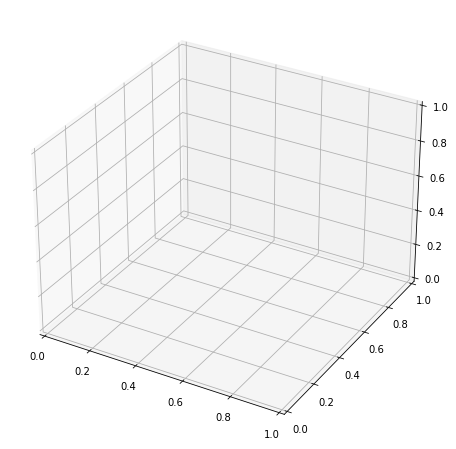

In [127]:
fig = plt.figure()
fig.set_size_inches(8, 8)
ax = plt.axes(projection='3d')

# plot_edge(ax, (77, 137))
# plot_face(ax, (102, 133, 134))
# plot_tetrahedron(ax, 400)

In [128]:
######### HELPER FUNCTIONS #########
def plot_node_bycoords(ax, nodecoords):
    ax.scatter(nodecoords[0], nodecoords[1], nodecoords[2], c='purple', s=200)
    
def plot_edge_bycoords(ax, edgestartcoords, edgeendcoords):
    # create parameterization between endpoints using parameter t
    t_array = np.linspace(0, 1, 50)
    for t in t_array:
        point = t*edgestartcoords + (1-t)*edgeendcoords
        ax.scatter(point[0], point[1], point[2], c='grey', s=20)

####################################
def plot_dual_node(ax, tetrahedron_id):
    dualnode_coords = dual_node_dict[tetrahedron_id]
    ax.scatter(dualnode_coords[0], dualnode_coords[1], dualnode_coords[2], c='blue', s=200)

def plot_dual_edge(ax, face_id):
    dual_edge_tetrahedrons = dual_edge_dict[face_id]
    for dual_edge_tetrahedron in dual_edge_tetrahedrons:
        plot_dual_node(ax, dual_edge_tetrahedron)
    
    start = dual_node_dict[dual_edge_tetrahedrons[0]] # this part is poorly written
    end = dual_node_dict[dual_edge_tetrahedrons[1]]
    plot_edge_bycoords(ax, start, end) 

def plot_dual_face(ax, edge_id):
    dual_edge_tetrahedrons = dual_face_dict[edge_id]
    for i in range(len(dual_edge_tetrahedrons)):
        
        plot_dual_node(ax, dual_edge_tetrahedrons[i])     
        
        start = dual_node_dict[dual_edge_tetrahedrons[i]] # this part is poorly written
        
        if i == len(dual_edge_tetrahedrons)-1: 
            end = dual_node_dict[dual_edge_tetrahedrons[0]]
        else:
            end = dual_node_dict[dual_edge_tetrahedrons[i+1]]
        
        plot_edge_bycoords(ax, start, end)

KeyError: 123

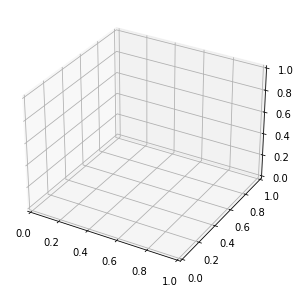

In [129]:
# %matplotlib notebook

fig = plt.figure()
fig.set_size_inches(5, 5)
ax = plt.axes(projection='3d')

# plot_face(ax, (133, 137, 138))
# plot_dual_edge(ax, (133, 137, 138))

plot_edge(ax, (123, 140))
plot_dual_face(ax, (123, 140))
# plot_dual_face(ax, (80, 137))
# plot_dual_face(ax, (48, 89))
# for tet_id in dual_face_dict[(80, 137)]:
#     plot_tetrahedron(ax, tet_id)

In [ ]:
dual_face_dict[(80, 137)]

#### Define function to find point st. it 1) lies on a plane defined by 3 points, 2) lies on a line passing through anther point which is normal to that plane:

In [ ]:
def get_boundary_node(face_id, tet_id):
    """
    - face_id defines the three vertices of the plane
    - tet_id defines the dual node through which the normal line must pass through
    """
    # get a,b,c,d in plane ax+by+cz+d=0
    plane_point_1 = np.array(node_dict[face_id[0]])
    plane_point_2 = np.array(node_dict[face_id[1]])
    plane_point_3 = np.array(node_dict[face_id[2]])
    plane_vector_1 = plane_point_2 - plane_point_1
    plane_vector_2 = plane_point_3 - plane_point_1
    normal_vector = np.cross(plane_vector_1, plane_vector_2) # coefficients define a,b,c
    a = normal_vector[0]
    b = normal_vector[1]
    c = normal_vector[2]
    d = -(normal_vector[0]*plane_point_1[0] + normal_vector[1]*plane_point_1[1] + normal_vector[2]*plane_point_1[2])
    dual_node_coords = dual_node_dict[tet_id]
    x_prime = dual_node_coords[0]
    y_prime = dual_node_coords[1]
    z_prime = dual_node_coords[2]
    # get point, see notes for how we got this eq
    t =  -(a*x_prime + b*y_prime + c*z_prime + d)/(a**2 + b**2 + c**2)
    return dual_node_coords + t * normal_vector

In [ ]:
fig = plt.figure()
fig.set_size_inches(5, 5)
ax = plt.axes(projection='3d')

# plot_tetrahedron(ax, 310)
# plot_face(ax, (92, 97, 102))
# plot_dual_node(ax, 310)
# plot_node_bycoords(ax, get_boundary_node((92, 97, 102), 310))


plot_face(ax, (103, 106, 107))


plot_dual_node(ax, 374)
plot_node_bycoords(ax, get_boundary_node((103, 106, 107), 374))

plot_edge_bycoords(ax, get_boundary_node((103, 106, 107), 374), dual_node_dict[374])

In [ ]:
boundary_dual_edge_dict = {}
"""
- key: 
    -face_id of a face which lies on the boundary of the mesh 
    -(i.e. it is only contained by one tet) (tuple of ints)
- value: coordinates  of the boundary dual node (np array of gloats)
"""

for face_id in face_dict:
    tets = face_dict[face_id]
    if np.size(tets) == 1:
        tet_id = tets[0]
        boundary_node_coords = get_boundary_node(face_id, tet_id)
        boundary_dual_edge_dict[face_id] = get_boundary_node(face_id, tet_id)

boundary_dual_edge_dict

#### plotting primal and dual edges purely by plotting edges

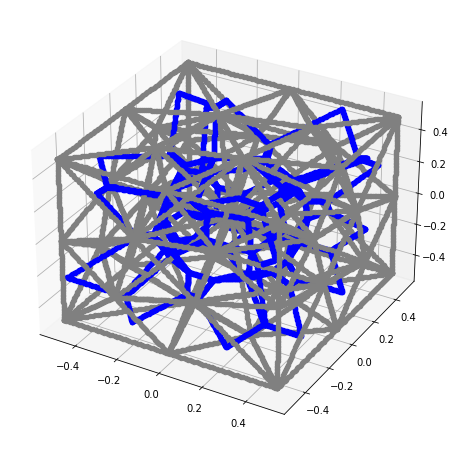

In [136]:
fig = plt.figure()
fig.set_size_inches(8, 8)
ax = plt.axes(projection='3d')

import matplotlib.pyplot as plt

def plot_edge_bycoords(ax, edgestartcoords, edgeendcoords):
    # create parameterization between endpoints using parameter t
    t_array = np.linspace(0, 1, 50)
    for t in t_array:
        point = t*edgestartcoords + (1-t)*edgeendcoords
        ax.scatter(point[0], point[1], point[2], c='grey', s=20)

for edge_id in edge_dict:
    start_node = edge_id[0]
    end_node = edge_id[1]
    start_coords = node_dict[start_node]
    end_coords = node_dict[end_node]
    plot_edge_bycoords(ax, start_coords, end_coords)
    
def plot_edge_bycoords(ax, edgestartcoords, edgeendcoords):
    # create parameterization between endpoints using parameter t
    t_array = np.linspace(0, 1, 50)
    for t in t_array:
        point = t*edgestartcoords + (1-t)*edgeendcoords
        ax.scatter(point[0], point[1], point[2], c='blue', s=20)
    
for dual_edge_tets in dual_edge_dict.values():
    start_tet = dual_edge_tets[0]
    end_tet = dual_edge_tets[1]
    start_coords = dual_node_dict[start_tet]
    end_coords = dual_node_dict[end_tet]
    plot_edge_bycoords(ax, start_coords, end_coords)

In [140]:
from mayavi import mlab

ValueError: PyCapsule_GetPointer called with incorrect name

# Scratchwork

#### plot one node

In [ ]:
fig = plt.figure()
fig.set_size_inches(8, 8)
ax = plt.axes(projection='3d')

node1coords = node_dict[1]
ax.scatter(node1coords[0], node1coords[1], node1coords[2], c='black', s=50)

In [ ]:
list(test.values())

In [ ]:
np.matrix([[-1.  , -0.5 , -0.25]]).shape